# RSA

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr
from tqdm import tqdm
import seaborn as sns
from itertools import combinations
from src.tools import corr2d

from joblib import Parallel, delayed

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, LeaveOneGroupOut

In [2]:
subj = 'subj001'
process = 'EEG_RSA'
run_pairwise = False
n_groups = 5

top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
rdm_path = f'{top_path}/data/interim/PairwiseDecoding/{subj}'
annotation_path = f'{top_path}/data/raw/annotations'
preproc_file = f'{top_path}/data/interim/SIdyads_EEG_pilot/{subj}/{subj}_preproc.mat'
figure_path = f'{top_path}/reports/figures/{process}'
out_path = f'{top_path}/data/interim/{process}'
fMRI_path = f'{top_path}/data/interim/fMRI_RSA'

Path(figure_path).mkdir(exist_ok=True, parents=True)
Path(out_path).mkdir(exist_ok=True, parents=True)

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
feature_order = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']

## Data Quality Check

### Load data

In [4]:
df = pd.read_csv(f'{top_path}/data/interim/SIdyads_EEG_pilot/{subj}/{subj}_trials.csv.gz')

In [5]:
preproc = loadmat(preproc_file)
artifact_trials = preproc['idx_badtrial'].squeeze().astype('bool')

In [6]:
trial_files = f'{top_path}/data/raw/SIdyads_trials_pilot/{subj}/timingfiles/*.csv'
trials = []
for run, tf in enumerate(sorted(glob(trial_files))):
    t = pd.read_csv(tf)
    t['run'] = run
    t['run_file'] = tf
    trials.append(t)
trials = pd.concat(trials).reset_index(drop=True)
trials['artifact_trial'] = artifact_trials
n_orig_trials = len(trials)
print(f'original number of trials: {n_orig_trials}')
trials = trials[~trials.artifact_trial].reset_index(drop=True)
trials.reset_index(inplace=True)
trials.rename(columns={'index': 'trial'}, inplace=True)
print(f'number of trials after EEG preprocessing: {len(trials)}')
print(f'percent of trials removed: {np.round(((n_orig_trials - len(trials))/n_orig_trials)*100):.0f}%')
print()
trials.head()

original number of trials: 2750
number of trials after EEG preprocessing: 2582
percent of trials removed: 6%



,trial,video_name,condition,block,onset_time,offset_time,duration,response,movie_path,run,run_file,artifact_trial
0,0,flickr-8-3-1-6897055831_10.mp4,1,1,2.039978,2.532425,0.492447,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
1,1,yt-Z02VjQcNxv0_5.mp4,1,1,3.290381,3.784469,0.494088,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
2,2,yt-7eF1aYP8gCQ_9.mp4,1,1,4.540973,5.034956,0.493983,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
3,3,yt-xp4X1QnB1GE_1595.mp4,1,1,9.542582,10.040772,0.498190,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False
4,4,flickr-1-6-4-12557575164_3.mp4,1,1,10.792678,11.292061,0.499382,0,C:\Users\cogsci-eeg\Documents\GitHub\SIdyads_E...,0,/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_...,False


In [7]:
df = pd.merge(df, trials[['trial', 'video_name', 'condition', 'response']], on='trial', how='left')
df.head()

,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,TP9,...,AF8,AF4,F2,FCz,Cz,time,trial,video_name,condition,response
0,12.211159,-0.365406,1.455867,-2.013593,-0.127816,5.429272,1.665105,7.438447,4.881617,-12.732592,...,-5.058898,-1.430098,-5.360655,-9.040224,-0.869286,-0.200,0,flickr-8-3-1-6897055831_10.mp4,1,0
1,9.665420,-0.115551,2.630108,-0.339936,-1.292479,3.607593,1.309161,4.435825,6.247282,-6.626344,...,-5.535029,-1.412960,-3.552274,-6.325364,-0.837621,-0.196,0,flickr-8-3-1-6897055831_10.mp4,1,0
2,7.373756,0.175655,3.591553,0.741411,-2.450310,2.531472,1.183165,2.048520,6.985805,-1.654644,...,-5.782101,-1.327114,-2.072576,-3.865864,-0.774688,-0.192,0,flickr-8-3-1-6897055831_10.mp4,1,0
3,5.648640,0.390788,4.183203,1.029836,-3.380554,2.427987,1.339860,0.625172,6.850772,1.419297,...,-5.512909,-1.146972,-1.235174,-1.985269,-0.714764,-0.188,0,flickr-8-3-1-6897055831_10.mp4,1,0
4,4.674086,0.341290,4.398996,0.685953,-3.859598,3.178077,1.693919,0.207284,6.114836,2.257891,...,-4.535619,-0.901405,-1.176704,-1.005106,-0.722316,-0.184,0,flickr-8-3-1-6897055831_10.mp4,1,0


### Decode crowd condition

Double check that we can decode the catch trials. This should be very easy to decode because the visual stimulus is very different and the participants are making a response on these trials. 

In [8]:
crowd_df = df.groupby(['time', 'video_name']).mean().reset_index()
crowd_df.head()

,time,video_name,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,...,FT8,F6,AF8,AF4,F2,FCz,Cz,trial,condition,response
0,-0.2,-3apEFekLVY_9.mp4,2.580180,1.571742,2.543932,2.084374,-1.062857,3.010114,1.013330,-0.212711,...,0.017709,0.240373,5.346932,0.309072,2.773080,-0.552846,-0.727040,1320.777778,0.0,1.0
1,-0.2,-YwZOeyAQC8_15.mp4,2.079488,1.005352,0.865753,1.520152,-0.808673,1.444873,1.469789,2.900839,...,2.353977,-0.484369,-4.022832,-1.267474,1.339167,-5.313114,1.849263,1231.300000,1.0,0.0
2,-0.2,1AIVH5cEWrI_35.mp4,0.037930,-2.399757,1.903024,-1.919979,-3.287206,-3.983391,-0.486708,3.227318,...,2.288034,0.510476,-0.796438,-1.681308,-0.960552,-2.926749,1.416367,1284.800000,1.0,0.1
3,-0.2,2-8-0-2-5-4-8-8-5028025488_7.mp4,0.503334,1.421777,-1.165836,1.014844,0.535332,2.693193,0.669675,-0.462479,...,4.558380,-1.465782,2.714343,0.459703,1.483236,-4.627260,0.317777,1331.111111,1.0,0.0
4,-0.2,2KvODAvWWrQ_130.mp4,-0.914351,-3.984762,-4.121077,-0.090248,2.023544,-4.293188,-1.543850,-3.704019,...,1.778731,-1.222289,6.689495,-1.848029,-2.561674,2.993798,0.102251,1052.666667,0.0,1.0


In [9]:
# identify channel columns
channels = crowd_df.drop(columns=['time', 'video_name', 'trial', 'condition', 'response']).columns

# initialize pipe and kfold splitter
cv = KFold(n_splits=10, shuffle=True, random_state=0)
pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])

# decode condition at each time point
results = []
chance = None
time_groups = crowd_df.groupby('time')
for time, time_df in tqdm(time_groups):
    time_df.reset_index(inplace=True)
    X = time_df[channels].to_numpy()
    y = time_df.condition.to_numpy().astype('int')
    if chance is None:
        chance = np.sum(y) / len(y)
    scores = []
    for train_index, test_index in cv.split(X):
        pipe.fit(X[train_index], y[train_index])
        scores.append(pipe.score(X[test_index], y[test_index]))
    results.append([time, np.mean(scores)])
results = pd.DataFrame(results, columns=['time', 'accuracy'])

100%|██████████| 200/200 [01:09<00:00,  2.86it/s]


Plot the results. We should see that an increase in decoding accuracy after the onset of the stimulus

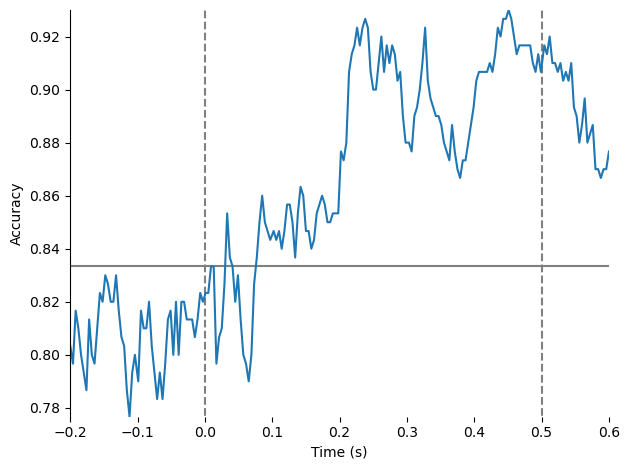

In [10]:
ymin, ymax = results.accuracy.min(), results.accuracy.max()

_, ax = plt.subplots()
sns.lineplot(x='time', y='accuracy', data=results, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
    colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=chance, xmin=results.time.min(), xmax=results.time.max(),
    colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([results.time.min(), results.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_crowd-decoding.png')

### Remove crowd videos

Now remove the crowd videos or any false alarm trials from all subsequent analyses.

In [11]:
catch_trials = np.invert(df.condition.to_numpy().astype('bool'))
response_trials = df.response.to_numpy().astype('bool')
trial_to_remove = catch_trials + response_trials
df_filtered = df[~trial_to_remove].reset_index(drop=True).drop(columns=['condition', 'response'])
# df_filtered.to_csv(f'{out_path}/{subj}_raw-filtered.csv', index=False)
df_filtered.head()

,Fp1,Fz,F3,F7,FT9,FC5,FC1,C3,T7,TP9,...,FT8,F6,AF8,AF4,F2,FCz,Cz,time,trial,video_name
0,12.211159,-0.365406,1.455867,-2.013593,-0.127816,5.429272,1.665105,7.438447,4.881617,-12.732592,...,-7.618311,-2.278209,-5.058898,-1.430098,-5.360655,-9.040224,-0.869286,-0.200,0,flickr-8-3-1-6897055831_10.mp4
1,9.665420,-0.115551,2.630108,-0.339936,-1.292479,3.607593,1.309161,4.435825,6.247282,-6.626344,...,-3.664458,-0.328237,-5.535029,-1.412960,-3.552274,-6.325364,-0.837621,-0.196,0,flickr-8-3-1-6897055831_10.mp4
2,7.373756,0.175655,3.591553,0.741411,-2.450310,2.531472,1.183165,2.048520,6.985805,-1.654644,...,-0.488548,1.152603,-5.782101,-1.327114,-2.072576,-3.865864,-0.774688,-0.192,0,flickr-8-3-1-6897055831_10.mp4
3,5.648640,0.390788,4.183203,1.029836,-3.380554,2.427987,1.339860,0.625172,6.850772,1.419297,...,1.483360,1.937810,-5.512909,-1.146972,-1.235174,-1.985269,-0.714764,-0.188,0,flickr-8-3-1-6897055831_10.mp4
4,4.674086,0.341290,4.398996,0.685953,-3.859598,3.178077,1.693919,0.207284,6.114836,2.257891,...,2.327462,2.081723,-4.535619,-0.901405,-1.176704,-1.005106,-0.722316,-0.184,0,flickr-8-3-1-6897055831_10.mp4


### Reliability

#### Split-half reliability
Calculate the reliability in roughly even splits of the data depending on the presentation order

In [12]:
df_filtered['repetition'] = df_filtered.groupby(['time', 'video_name']).cumcount() + 1
df_filtered['even'] = False
df_filtered.loc[(df_filtered.repetition % 2) == 0, 'even'] = True
df_split = df_filtered.groupby(['time', 'video_name', 'even']).mean().reset_index()

In [13]:
results = []
time_groups = df_split.groupby('time')
for time, time_df in time_groups:
    even = time_df[time_df.even].sort_values('video_name')
    odd = time_df[~time_df.even].sort_values('video_name')
    rs = corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
    results.append([time,] + list(rs))
results = pd.DataFrame(results, columns=['time',] + channels.to_list())
results = pd.melt(results, id_vars=['time'], value_vars=channels, var_name='channel', value_name='reliability')

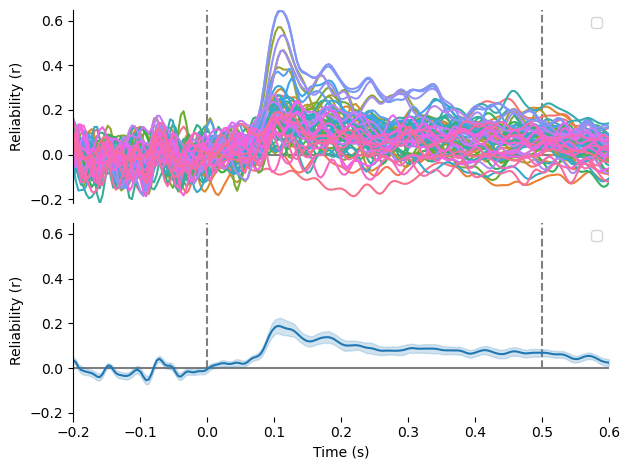

In [14]:
ymin, ymax = results.reliability.min(), results.reliability.max()

_, axes = plt.subplots(2, sharex=True)
for i, ax in enumerate(axes):
    if i == 0:
        sns.lineplot(x='time', y='reliability', hue='channel',
                     data=results, ax=ax)
        ax.tick_params(axis='x', which='both', length=0)
    else:
        sns.lineplot(x='time', y='reliability',
                data=results, ax=ax)
        ax.set_xlabel('Time (s)')
    ax.set_ylabel('Reliability (r)')
    ax.hlines(y=0, xmin=results.time.min(), xmax=results.time.max(),
        colors='gray', linestyles='solid', zorder=0)
    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
    ax.set_xlim([results.time.min(), results.time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.legend([])
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_reliability.png')

#### Repetition reliability

Determine whether there is a plateau in the reliability based on the number of repeitions

In [15]:
results = []
min_repeats = df_filtered.groupby('video_name').repetition.max().min()
time_groups = df_filtered.groupby('time')
for time, time_df in tqdm(time_groups):
    time_df.set_index(['repetition', 'video_name'], inplace=True)
    for n_samples in range(2, min_repeats, 2):
        inds = np.random.choice(min_repeats, n_samples, replace=False) + 1
        inds = inds.reshape((2, -1))
        even = time_df.loc[inds[0]].reset_index().groupby('video_name').mean()
        odd = time_df.loc[inds[1]].reset_index().groupby('video_name').mean()
        rs = corr2d(even[channels].to_numpy(), odd[channels].to_numpy())
        results.append([time, n_samples] + list(rs))
results = pd.DataFrame(results, columns=['time', 'n_samples'] + channels.to_list())
results = pd.melt(results, id_vars=['time', 'n_samples'], value_vars=channels, var_name='channel', value_name='reliability')

100%|██████████| 200/200 [00:06<00:00, 33.20it/s]


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_9395/1481842334.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_res_avg = results.groupby(['time', 'n_samples']).mean().reset_index()


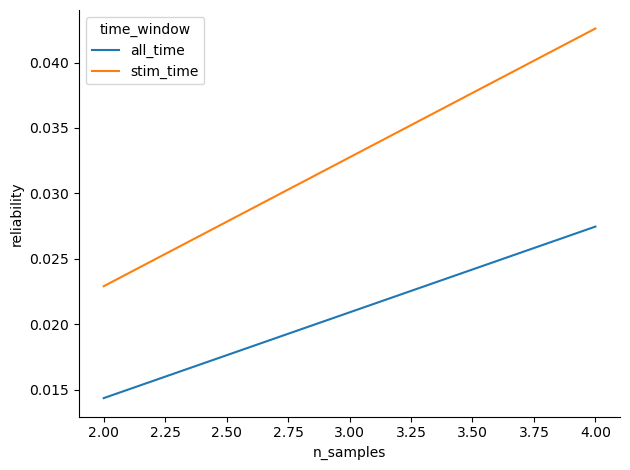

In [16]:
time_res_avg = results.groupby(['time', 'n_samples']).mean().reset_index()
time_avg = time_res_avg.groupby('n_samples').mean().reset_index()
time_avg['time_window'] = 'all_time'
stim_time_avg = time_res_avg.loc[(time_res_avg.time > .1) & (time_res_avg.time < .6)].groupby('n_samples').mean().reset_index()
stim_time_avg['time_window'] = 'stim_time'
time_avg = pd.concat([time_avg, stim_time_avg])


_, ax = plt.subplots()
sns.lineplot(x='n_samples', y='reliability', hue='time_window',
                 data=time_avg, ax=ax, markers=True, dashes=False)
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(f'{figure_path}/{subj}_reliability-curve.png')

### Pairwise decoding

In [17]:
def divide_into_groups(arr, n_groups=5):
    n = len(arr)
    
    # Calculate the size of each group
    group_size = n // n_groups
    remainder = n % n_groups
    
    groups = []
    start_idx = 0
    
    for i in range(n_groups):
        end_idx = start_idx + group_size + (i < remainder)  # Add 1 if this group takes an extra element
        group = arr[start_idx:end_idx]
        groups.append(group)
        start_idx = end_idx  # Update the starting index for the next group
        
    return groups

In [18]:
def generate_pseudo(arr, n_groups=5):
    inds = np.arange(len(arr))
    np.random.shuffle(inds)
    groups = divide_into_groups(inds, n_groups)
    pseudo_arr = []
    for group in groups:
        pseudo_arr.append(arr[group].mean(axis=0))
    return np.array(pseudo_arr)

In [19]:
def fit_and_predict(video1_array, video2_array, n_groups):
    #regenerate to ensure that it is thread safe
    logo = LeaveOneGroupOut()
    pipe = Pipeline([('scale', StandardScaler()), ('lr', LogisticRegression())])

    #define X, y, and groups to loop through
    X = np.vstack([generate_pseudo(video1_array, n_groups),
                    generate_pseudo(video2_array, n_groups)])
    y = np.hstack([np.zeros((n_groups)), np.ones((n_groups))]).astype('int')
    groups = np.concatenate([np.arange(n_groups), np.arange(n_groups)])

    #fit and predict 
    y_pred = []
    y_true = []
    for train_index, test_index in logo.split(X, y, groups=groups):
        pipe.fit(X[train_index], y[train_index])
        y_pred.append(pipe.predict(X[test_index]))
        y_true.append(y[test_index])
        
    #Return the mean prediction acurracy over all groups
    return np.mean(np.array(y_pred) == np.array(y_true))

In [20]:
df_filtered.sort_values(['time', 'video_name'], inplace=True)
videos = df_filtered.video_name.unique()
videos_nCk = list(combinations(videos, 2))
channels = df_filtered.drop(columns=['time', 'trial', 'video_name']).columns

if run_pairwise:
    results = []
    time_groups = df_filtered.groupby('time')
    for time, time_df in tqdm(time_groups, total=len(time_groups)):
        result_for_t = Parallel(n_jobs=-1)(
            delayed(fit_and_predict)(time_df.loc[time_df.video_name == video1, channels].to_numpy(),
                                     time_df.loc[time_df.video_name == video2, channels].to_numpy(),
                                     n_groups) for video1, video2 in videos_nCk
        )
        for accuracy, (video1, video2) in zip(result_for_t, videos_nCk):
            results.append([time, video1, video2, accuracy])
    results = pd.DataFrame(results, columns=['time', 'video1', 'video2', 'accuracy'])
    results.to_csv(f'{out_path}/{subj}_pairwise-decoding.csv', index=False)
else:
    results = pd.read_csv(f'{out_path}/{subj}_pairwise-decoding.csv')

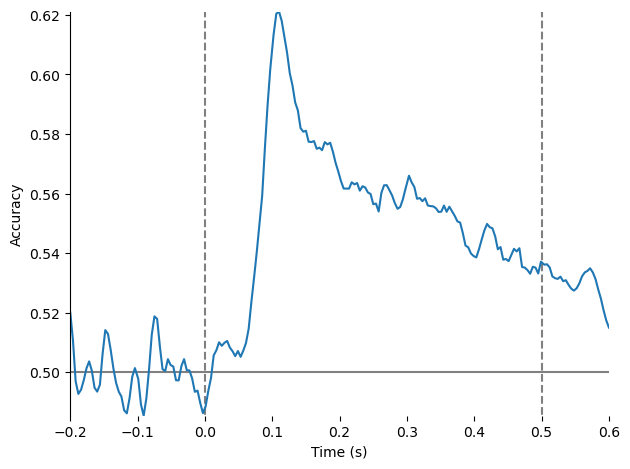

In [21]:
avg_results = results.groupby('time').mean(numeric_only=True)
ymin, ymax = avg_results.accuracy.min(), avg_results.accuracy.max()

_, ax = plt.subplots()
sns.lineplot(x='time', y='accuracy', data=avg_results, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
    colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=.5, xmin=results.time.min(), xmax=results.time.max(),
    colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([results.time.min(), results.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_pairwise-decoding.png')

## Feature RDMs

Load the feature annotations and make the RDMs. Care needs to be paid to ensure that that the order of the vidoes across the two RDMs is consistent. 

In [22]:
features_to_exclude = ['dominance', 'cooperation', 'intimacy']
df = pd.read_csv(f'{annotation_path}/annotations.csv')
df = df.merge(pd.read_csv(f'{annotation_path}/test.csv'), on='video_name').set_index('video_name')
df = df.drop(columns=features_to_exclude)
rename = {col: col.replace(' ', '_') for col in df.columns}
rename['transitivity'] = 'object_directedness'
df.rename(columns=rename, inplace=True)
df.sort_index(inplace=True)

alexnet = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/alexnet_PCs.csv').drop(columns=['split'])
df = df.merge(alexnet, on='video_name')

moten = pd.read_csv(f'{top_path}/data/interim/ActivationPCA/moten_PCs.csv').drop(columns=['split'])
df = df.merge(moten, on='video_name')

df.head()

,video_name,indoor,expanse,object_directedness,agent_distance,facingness,joint_action,communication,valence,arousal,...,alexnet_PC13,alexnet_PC14,alexnet_PC15,alexnet_PC16,alexnet_PC17,alexnet_PC18,alexnet_PC19,moten_PC0,moten_PC1,moten_PC2
0,3PJaYWt0cws_5.mp4,0,0.625000,1.000000,0.725000,0.340909,0.022727,0.1500,0.600,0.400000,...,-0.361651,13.382875,18.030890,12.732855,2.805191,5.295271,7.270865,-8.642924,11.198228,-8.109102
1,9hlyu-wDkg4_4.mp4,0,0.275000,0.025000,0.150000,0.875000,0.425000,0.9250,0.500,0.025000,...,0.782414,6.846017,2.404510,-7.611230,-5.513788,3.289649,-6.939750,-4.993299,0.421083,12.959665
2,flickr-0-6-1-2-0-7-8-4-4606120784_26.mp4,1,0.475000,0.977273,0.475000,0.150000,0.825000,0.7000,0.550,0.363636,...,-21.328934,9.207804,-7.677331,5.646554,4.078122,-6.472103,-9.998116,39.614520,-2.978275,4.671895
3,flickr-1-1-2-0-2-4-6-6-7211202466_8.mp4,0,0.550000,0.550000,0.568182,0.200000,0.416667,0.6875,0.775,0.500000,...,-18.728868,-9.681856,-6.215109,-4.807743,7.121509,8.405329,8.402653,0.272742,3.830476,12.432661
4,flickr-2-0-5-7-0-2-3-3-4720570233_26.mp4,1,0.229167,0.975000,0.300000,0.200000,0.431818,0.7000,0.600,0.375000,...,0.453632,-5.220378,1.330756,2.071345,-20.504118,-4.486245,-5.107946,-18.957924,-3.096069,0.527389


In [27]:
video_set = df.video_name.unique()
videos_nCk = list(combinations(video_set, 2))
feature_rdms = []
for feature in tqdm(feature_order):
    if 'alexnet' == feature or 'moten' == feature:
        cols = [col for col in df.columns if feature in col]
        array = df[cols].to_numpy()
        distance_matrix = pdist(array, metric='correlation')
    else: 
        array = np.expand_dims(df[feature].to_numpy(), axis=1)
        distance_matrix = pdist(array, metric='euclidean')
        
    for idx, (video1, video2) in enumerate(videos_nCk):
        feature_rdms.append([video1, video2, feature, distance_matrix[idx]])
feature_rdms = pd.DataFrame(feature_rdms, columns=['video1', 'video2', 'feature', 'distance'])
feature_rdms.head()
    

NameError: name 'set_video' is not defined

## Correlate Feature and Neural RDMs

In [26]:
rolling_results = results.groupby(['video1', 'video2']).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())
rolling_results = rolling_results.reset_index().dropna()
print(len(rolling_results.time.unique()))

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_9395/68679846.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['video1', 'video2'], dtype='object')
  rolling_results = results.groupby(['video1', 'video2']).apply(lambda x: x.rolling(window=5, min_periods=2, step=2).mean())


99


In [29]:
rolling_results = rolling_results.loc[rolling_results['video1'].isin(video_set)]
rolling_results = rolling_results.loc[rolling_results['video2'].isin(video_set)]

In [30]:
feature_group = feature_rdms.groupby('feature')
neural_group = rolling_results.groupby('time')
rsa = []
for feature, feature_rdm in tqdm(feature_group):
    for time, time_rdm in neural_group:
        rho, _ = spearmanr(feature_rdm.distance, time_rdm.accuracy)
        rsa.append([feature, time, rho])
rsa = pd.DataFrame(rsa, columns=['feature', 'time', 'Spearman rho'])
cat_type = pd.CategoricalDtype(categories=feature_order, ordered=True)
rsa['feature'] = rsa.feature.astype(cat_type)
rsa.to_csv(f'{out_path}/{subj}_feature-rsa.csv')
rsa.head()

100%|██████████| 11/11 [00:00<00:00, 12.95it/s]


,feature,time,Spearman rho
0,agent_distance,-0.196,-0.032832
1,agent_distance,-0.192,-0.031866
2,agent_distance,-0.184,-0.020389
3,agent_distance,-0.176,0.009961
4,agent_distance,-0.168,0.016891


In [31]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_9395/3698014574.py:31: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


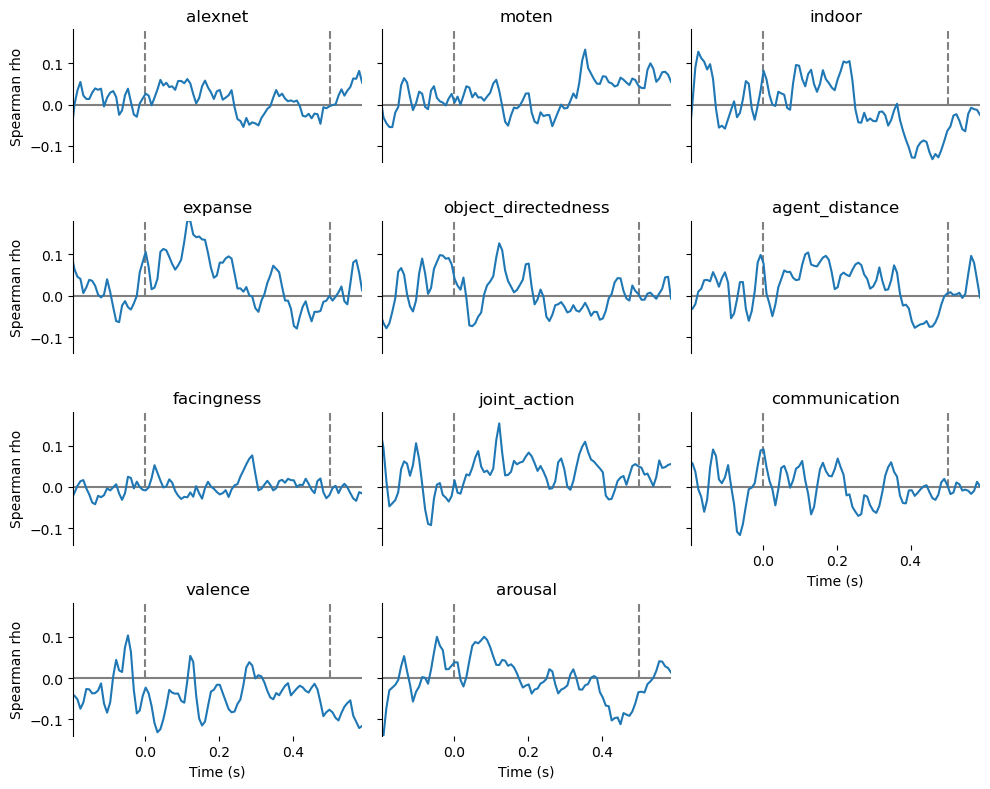

In [32]:
feature_group = rsa.groupby('feature')
_, axes = plt.subplots(int(np.ceil(len(feature_order)/3)), 3,
                       figsize=(10,8),
                       sharey=True, constrained_layout=True)
axes = axes.flatten()
trim_axs(axes, len(feature_order))
ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
for ax, (feature, time_corr) in zip(axes, feature_group):
    sns.lineplot(x='time', y='Spearman rho', data=time_corr, ax=ax)
    if feature in ['alexnet', 'expanse', 'facingness', 'valence']:
        ax.set_ylabel('Spearman rho')
    else:
        ax.set_ylabel('')
        
    if feature in ['communication', 'valence', 'arousal']:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        ax.tick_params(axis='x', which='both', length=0)
    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
            colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
            colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(feature)
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_feature-rsa.png')

## Correlate EEG and fMRI RDMs

In [33]:
decoding = True
if decoding:
    suffix = 'decoding'
else:
    suffix = 'correlation'

In [34]:
files = glob(f'{fMRI_path}/*set-test*{suffix}.csv')
fmri_rdms = []
for file in files:
    fr = pd.read_csv(file)
    fmri_subj_name = file.split('/')[-1].split('_')[0]
    fr['subj'] = fmri_subj_name
    fmri_rdms.append(fr)
fmri_rdms = pd.concat(fmri_rdms)
fmri_rdms = fmri_rdms.groupby(['roi', 'video1', 'video2']).mean().reset_index()
fmri_rdms.sort_values(by=['roi', 'video1', 'video2'])
fmri_rdms.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_9395/4180646998.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  fmri_rdms = fmri_rdms.groupby(['roi', 'video1', 'video2']).mean().reset_index()


,roi,video1,video2,Unnamed: 0,Spearman rho,distance
0,EBA,3PJaYWt0cws_5.mp4,9hlyu-wDkg4_4.mp4,NaN,NaN,0.975
1,EBA,3PJaYWt0cws_5.mp4,flickr-0-6-1-2-0-7-8-4-4606120784_26.mp4,NaN,NaN,0.925
2,EBA,3PJaYWt0cws_5.mp4,flickr-1-1-2-0-2-4-6-6-7211202466_8.mp4,NaN,NaN,0.950
3,EBA,3PJaYWt0cws_5.mp4,flickr-2-0-5-7-0-2-3-3-4720570233_26.mp4,NaN,NaN,0.975
4,EBA,3PJaYWt0cws_5.mp4,flickr-2-1-6-6-7-1-1-2-16621667112_15.mp4,NaN,NaN,0.950


In [36]:
roi_group = fmri_rdms.groupby('roi')
neural_group = rolling_results.groupby('time')
rsa = []
for roi, roi_rdm in tqdm(roi_group):
    for time, time_rdm in neural_group:
        rho, _ = spearmanr(roi_rdm.distance, time_rdm.accuracy)
        rsa.append([roi, time, rho])
rsa = pd.DataFrame(rsa, columns=['roi', 'time', 'Spearman rho'])
cat_type = pd.CategoricalDtype(categories=rois, ordered=True)
rsa['roi'] = rsa.roi.astype(cat_type)
rsa.to_csv(f'{out_path}/{subj}_fMRI-{suffix}-rsa.csv')
rsa.head()

100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


,roi,time,Spearman rho
0,EBA,-0.196,-0.004437
1,EBA,-0.192,-0.017274
2,EBA,-0.184,-0.007412
3,EBA,-0.176,-0.004875
4,EBA,-0.168,-0.006570


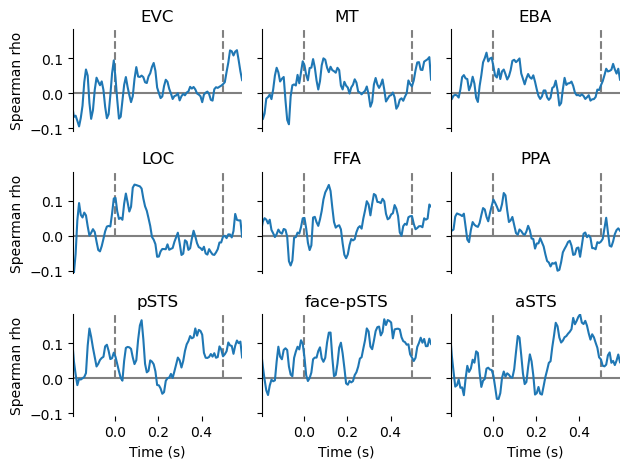

In [37]:
roi_group = rsa.groupby('roi')
_, axes = plt.subplots(3, 3, sharey=True, sharex=True)
axes = axes.flatten()
ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
for ax, (roi, roi_corr) in zip(axes, roi_group):
    sns.lineplot(x='time', y='Spearman rho', data=roi_corr, ax=ax)
    if roi in ['EVC', 'LOC', 'pSTS']:
        ax.set_ylabel('Spearman rho')
    else:
        ax.set_ylabel('')

    if roi in ['pSTS', 'face-pSTS', 'aSTS']:
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xlabel('')
        ax.tick_params(axis='x', which='both', length=0)

    ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
            colors='gray', linestyles='dashed', zorder=0)
    ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
            colors='gray', linestyles='solid', zorder=0)
    ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
    ax.set_ylim([ymin, ymax])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title(roi)
plt.tight_layout()
plt.savefig(f'{figure_path}/{subj}_fMRI-{suffix}-rsa.png')